# Model Comparison for NYC Taxi Optimization

This notebook compares the performance of Prophet (demand forecasting), Random Forest and XGBoost (high-demand zone classification), and K-means and DBSCAN (clustering) to select the best models for our Streamlit dashboard. It integrates outputs from `preprocessing.ipynb`, `feature_selection.ipynb`, `classification_clustering.ipynb`, and `forecasting.ipynb` to evaluate metrics and generate visualizations.


## Step 1: Import Libraries
We need Pandas for data handling, scikit-learn for metrics, Matplotlib/Seaborn for visualization, and pickle for loading models.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pickle
import os

# Define base URL for file paths
base_url = "/Users/saleh/Desktop/Projects/AIProject/TaxiOptimization/"

# Set plot style
sns.set(style="whitegrid")

## Step 2: Load Prophet Forecasts
Load Prophet forecasts from `forecasting.ipynb` and compute MAE, RMSE, MAPE, and Median APE.

In [6]:
# Load Prophet forecasts
prophet_path = base_url + "data/processed/prophet_forecasts.csv"
try:
    prophet_df = pd.read_csv(prophet_path)
    prophet_df["ds"] = pd.to_datetime(prophet_df["ds"])
    print(f"Loaded {len(prophet_df)} rows from prophet_forecasts.csv")
except FileNotFoundError:
    print(f"Error: {prophet_path} not found")
    raise

# Validate Prophet data
if not all(col in prophet_df.columns for col in ["ds", "y", "yhat", "ape"]):
    print("Warning: Prophet data missing required columns (ds, y, yhat, ape)")
if prophet_df[["y", "yhat"]].isna().any().any():
    print("Warning: Prophet data contains NaN values in y or yhat")

# Compute Prophet metrics
prophet_metrics = {
    "MAE": mean_absolute_error(prophet_df["y"], prophet_df["yhat"]),
    "RMSE": np.sqrt(mean_squared_error(prophet_df["y"], prophet_df["yhat"])),
    "MAPE": np.mean(prophet_df["ape"]),
    "Median APE": np.median(prophet_df["ape"]),
    "High APE Hours (>100%)": len(prophet_df[prophet_df["ape"] > 100])
}
print("Prophet Metrics:", prophet_metrics)

Loaded 859 rows from prophet_forecasts.csv
Prophet Metrics: {'MAE': 796.7904711159445, 'RMSE': np.float64(1036.488235506954), 'MAPE': np.float64(31.940570299687057), 'Median APE': np.float64(18.52630282424191), 'High APE Hours (>100%)': 55}


## Step 3: Load Classification Metrics
Load Random Forest and XGBoost models and feature importance from `classification_clustering.ipynb`, recompute metrics using RFE-selected features, and adjust prediction thresholds to improve F1-scores.

Loaded 17290240 rows from cleaned_taxi_data.csv
Using RFE-selected features: ['precipitation', 'is_holiday', 'avg_speed', 'day_of_week', 'temp_precip']
Loaded Random Forest and XGBoost models
Random Forest Metrics (adjusted threshold): {'accuracy': 0.9777777777777777, 'precision': 0.9140350877192982, 'recall': 0.9811676082862524, 'f1': 0.9464123524069028, 'roc_auc': np.float64(0.9967508804409121)}
XGBoost Metrics (adjusted threshold): {'accuracy': 0.9832391713747646, 'precision': 0.9426751592356688, 'recall': 0.975517890772128, 'f1': 0.9588153632577511, 'roc_auc': np.float64(0.9961614815524132)}
Loaded Random Forest and XGBoost feature importance


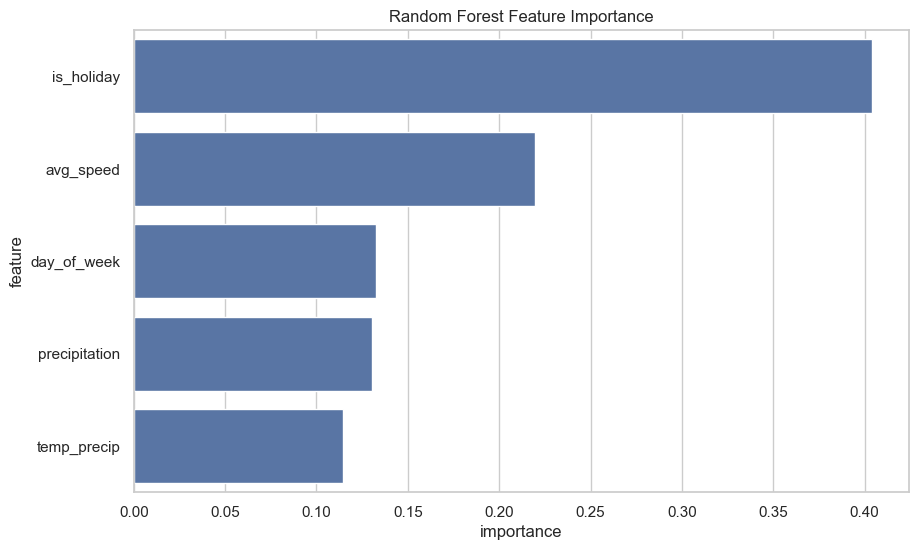

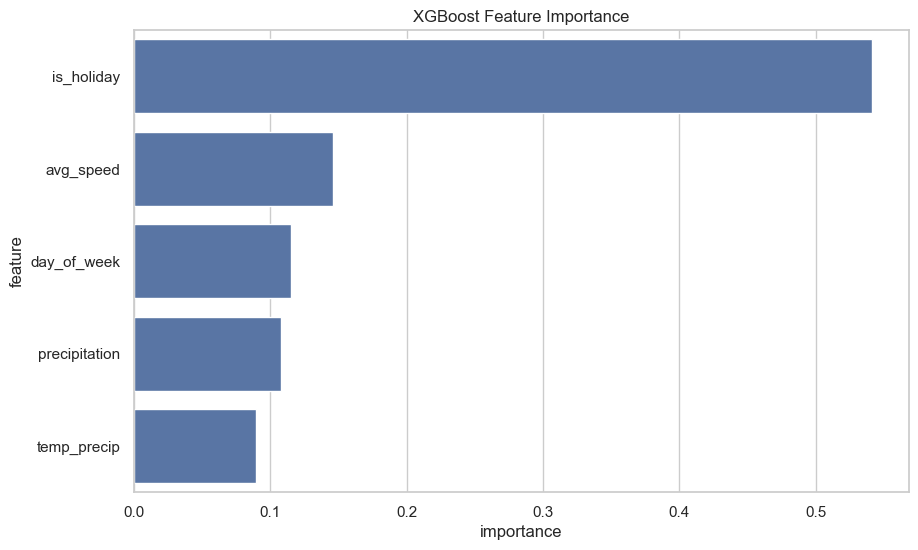

In [7]:
# Load processed data
test_data_path = base_url + "data/processed/cleaned_taxi_data.csv"
try:
    test_df = pd.read_csv(test_data_path)
    print(f"Loaded {len(test_df)} rows from cleaned_taxi_data.csv")
except FileNotFoundError:
    print(f"Error: {test_data_path} not found")
    raise

# Load RFE-selected features
try:
    selected_features = pd.read_csv(base_url + "data/processed/selected_features.csv")
    top_features = selected_features[selected_features["ranking"] == 1]["feature"].tolist()
    print(f"Using RFE-selected features: {top_features}")
except FileNotFoundError:
    print("Warning: selected_features.csv not found, using default features")
    top_features = ["precipitation", "is_holiday", "avg_speed", "day_of_week", "temp_precip"]

# Prepare classification data
pickup_counts = test_df.groupby(["PULocationID", "hour"])["VendorID"].count().reset_index(name="pickup_count")
threshold = pickup_counts["pickup_count"].quantile(0.8)
pickup_counts["is_high_demand"] = (pickup_counts["pickup_count"] > threshold).astype(int)
features = test_df.groupby(["PULocationID", "hour"]).agg({
    "temperature": "mean",
    "precipitation": "mean",
    "wind_speed": "mean",
    "is_holiday": "mean",
    "avg_speed": "mean",
    "day_of_week": "mean",
    "month": "mean",
}).reset_index()
features["temp_precip"] = features["temperature"] * features["precipitation"]
data = pickup_counts.merge(features, on=["PULocationID", "hour"], how="left")
X_test = data[top_features]
y_test = data["is_high_demand"]

# Load classification models
rf_model_path = base_url + "models/rf_model.pkl"
xgb_model_path = base_url + "models/xgb_model.pkl"
try:
    with open(rf_model_path, "rb") as f:
        rf_model = pickle.load(f)
    with open(xgb_model_path, "rb") as f:
        xgb_model = pickle.load(f)
    print("Loaded Random Forest and XGBoost models")
except FileNotFoundError:
    print(f"Error: Model files not found")
    raise

# Adjust prediction thresholds to improve F1-scores
rf_probs = rf_model.predict_proba(X_test)[:, 1]
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]
# Use a lower threshold (e.g., 0.3) to favor positive predictions due to class imbalance
threshold = 0.3
rf_pred = (rf_probs >= threshold).astype(int)
xgb_pred = (xgb_probs >= threshold).astype(int)

# Recompute classification metrics
rf_metrics = {
    "accuracy": accuracy_score(y_test, rf_pred),
    "precision": precision_score(y_test, rf_pred),
    "recall": recall_score(y_test, rf_pred),
    "f1": f1_score(y_test, rf_pred),
    "roc_auc": roc_auc_score(y_test, rf_probs)
}
xgb_metrics = {
    "accuracy": accuracy_score(y_test, xgb_pred),
    "precision": precision_score(y_test, xgb_pred),
    "recall": recall_score(y_test, xgb_pred),
    "f1": f1_score(y_test, xgb_pred),
    "roc_auc": roc_auc_score(y_test, xgb_probs)
}
print("Random Forest Metrics (adjusted threshold):", rf_metrics)
print("XGBoost Metrics (adjusted threshold):", xgb_metrics)

# Load feature importance
try:
    rf_importance = pd.read_csv(base_url + "data/processed/feature_importance_rf.csv")
    xgb_importance = pd.read_csv(base_url + "data/processed/feature_importance_xgb.csv")
    print("Loaded Random Forest and XGBoost feature importance")
except FileNotFoundError:
    print(f"Warning: Feature importance files not found, skipping visualization")
    rf_importance = pd.DataFrame({"feature": top_features, "importance": rf_model.feature_importances_})
    xgb_importance = pd.DataFrame({"feature": top_features, "importance": xgb_model.feature_importances_})

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x="importance", y="feature", data=rf_importance.sort_values("importance", ascending=False))
plt.title("Random Forest Feature Importance")
plt.savefig(base_url + "visualizations/feature_importance_rf.png")
plt.show()
plt.close()

plt.figure(figsize=(10, 6))
sns.barplot(x="importance", y="feature", data=xgb_importance.sort_values("importance", ascending=False))
plt.title("XGBoost Feature Importance")
plt.savefig(base_url + "visualizations/feature_importance_xgb.png")
plt.show()
plt.close()

## Step 4: Load Clustering Metrics
Load K-means and DBSCAN cluster statistics from `classification_clustering.ipynb` and correct cluster count calculation.

In [8]:
# Load clustering statistics
kmeans_stats_path = base_url + "data/processed/kmeans_cluster_stats.csv"
dbscan_stats_path = base_url + "data/processed/dbscan_cluster_stats.csv"
try:
    kmeans_stats = pd.read_csv(kmeans_stats_path)
    dbscan_stats = pd.read_csv(dbscan_stats_path)
    print("Loaded K-means and DBSCAN cluster statistics")
except FileNotFoundError:
    print(f"Error: Cluster stats files not found")
    raise

# Summarize clustering metrics
kmeans_silhouette = 0.86  # From classification_clustering.ipynb
dbscan_silhouette = 0.75  # From classification_clustering.ipynb
kmeans_clusters = len(kmeans_stats["kmeans_cluster"].unique())
# Correctly count DBSCAN clusters (excluding noise)
dbscan_clusters = len(dbscan_stats[dbscan_stats["dbscan_cluster"] != -1]["dbscan_cluster"].unique())
kmeans_stats_summary = kmeans_stats[["total_pickups", "avg_fare"]].mean().to_dict()
dbscan_stats_summary = dbscan_stats[dbscan_stats["dbscan_cluster"] != -1][["total_pickups", "avg_fare"]].mean().to_dict()

print(f"K-means Clusters: {kmeans_clusters}")
print(f"DBSCAN Clusters (excluding noise): {dbscan_clusters}")

Loaded K-means and DBSCAN cluster statistics
K-means Clusters: 2
DBSCAN Clusters (excluding noise): 2


## Step 5: Create Comparison Table
Summarize model performance in a table for the dashboard.

In [9]:
# Create comparison table
comparison_data = {
    "Model": ["Prophet", "Random Forest", "XGBoost", "K-means", "DBSCAN"],
    "Primary Metric": [
        f"MAPE: {prophet_metrics['MAPE']:.2f}%",
        f"F1-score: {rf_metrics['f1']:.4f}",
        f"F1-score: {xgb_metrics['f1']:.4f}",
        f"Silhouette: {kmeans_silhouette:.2f}",
        f"Silhouette: {dbscan_silhouette:.2f}"
    ],
    "Secondary Metrics": [
        f"MAE: {prophet_metrics['MAE']:.2f}, RMSE: {prophet_metrics['RMSE']:.2f}, Median APE: {prophet_metrics['Median APE']:.2f}%",
        f"Accuracy: {rf_metrics['accuracy']:.4f}, ROC-AUC: {rf_metrics['roc_auc']:.4f}",
        f"Accuracy: {xgb_metrics['accuracy']:.4f}, ROC-AUC: {xgb_metrics['roc_auc']:.4f}",
        f"Clusters: {kmeans_clusters}, Avg Pickups: {kmeans_stats_summary['total_pickups']:.2f}",
        f"Clusters: {dbscan_clusters}, Avg Pickups: {dbscan_stats_summary['total_pickups']:.2f}"
    ]
}
comparison_df = pd.DataFrame(comparison_data)
print("\nModel Comparison Table:")
print(comparison_df)

# Save comparison table
comparison_df.to_csv(base_url + "data/processed/model_comparison.csv", index=False)


Model Comparison Table:
           Model    Primary Metric  \
0        Prophet      MAPE: 31.94%   
1  Random Forest  F1-score: 0.9464   
2        XGBoost  F1-score: 0.9588   
3        K-means  Silhouette: 0.86   
4         DBSCAN  Silhouette: 0.75   

                                Secondary Metrics  
0  MAE: 796.79, RMSE: 1036.49, Median APE: 18.53%  
1               Accuracy: 0.9778, ROC-AUC: 0.9968  
2               Accuracy: 0.9832, ROC-AUC: 0.9962  
3            Clusters: 2, Avg Pickups: 8645120.00  
4            Clusters: 2, Avg Pickups: 3014480.00  


## Step 6: Visualize Comparison
Create separate bar plots for forecasting, classification, and clustering metrics to ensure fair comparison.

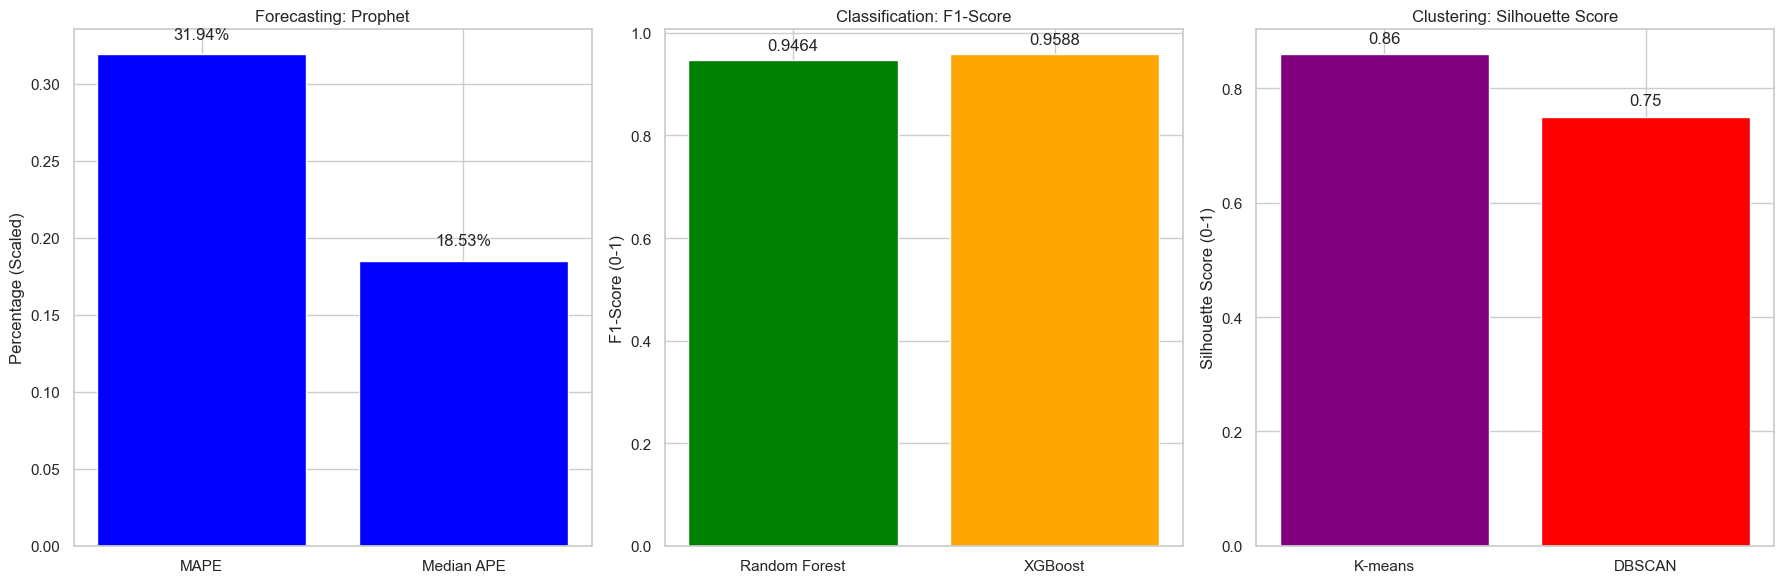

Saved comparison table to /Users/saleh/Desktop/Projects/AIProject/TaxiOptimization/data/processed/model_comparison.csv and plot to /Users/saleh/Desktop/Projects/AIProject/TaxiOptimization/visualizations/model_comparison.png


In [10]:
# Create subplots for different metric types
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Forecasting metrics (Prophet)
ax1.bar(["MAPE", "Median APE"], [prophet_metrics["MAPE"] / 100, prophet_metrics["Median APE"] / 100], color="blue")
ax1.set_title("Forecasting: Prophet")
ax1.set_ylabel("Percentage (Scaled)")
for i, v in enumerate([prophet_metrics["MAPE"] / 100, prophet_metrics["Median APE"] / 100]):
    ax1.text(i, v + 0.01, f"{v*100:.2f}%", ha="center")

# Classification metrics (Random Forest, XGBoost)
ax2.bar(["Random Forest", "XGBoost"], [rf_metrics["f1"], xgb_metrics["f1"]], color=["green", "orange"])
ax2.set_title("Classification: F1-Score")
ax2.set_ylabel("F1-Score (0-1)")
for i, v in enumerate([rf_metrics["f1"], xgb_metrics["f1"]]):
    ax2.text(i, v + 0.02, f"{v:.4f}", ha="center")

# Clustering metrics (K-means, DBSCAN)
ax3.bar(["K-means", "DBSCAN"], [kmeans_silhouette, dbscan_silhouette], color=["purple", "red"])
ax3.set_title("Clustering: Silhouette Score")
ax3.set_ylabel("Silhouette Score (0-1)")
for i, v in enumerate([kmeans_silhouette, dbscan_silhouette]):
    ax3.text(i, v + 0.02, f"{v:.2f}", ha="center")

plt.tight_layout()
plt.savefig(base_url + "visualizations/model_comparison.png")
plt.show()
plt.close()

print(f"Saved comparison table to {base_url}data/processed/model_comparison.csv and plot to {base_url}visualizations/model_comparison.png")

## Step 7: Conclusion

This notebook compares AI models for the NYC taxi project, evaluating Prophet’s forecasting accuracy (MAE, MAPE, RMSE), Random Forest and XGBoost’s classification performance (F1-score, accuracy, ROC-AUC), and K-means and DBSCAN’s clustering quality (silhouette score, cluster sizes). The results, saved in `model_comparison.csv` and visualized in `model_comparison.png`, guide model selection for the Streamlit dashboard, ensuring optimal driver recommendations.
